<a href="https://colab.research.google.com/github/tbeucler/2022_ML_EES/blob/main/Labs/S1_1_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook covers material from Chapters 3 of Géron, and builds on the original notebooks made [available on _Github_](https://github.com/ageron/handson-ml2).

# (Exercises) Classification

## Notebook Setup
The following cells will set up the libraries we need to run our classification tasks, as well as load the data we need to run a classifier on the MNIST handwritten digit database.

In [ ]:
#@title Run This cell to import common modules. Double click on this if you want to take a look at the code 😀
'''
First, let's import a few common modules, ensure MatplotLib plots figures inline
and prepare a function to save the figures. We also check that Python 3.5 or 
later is installed (although Python 2.x may work, it is deprecated so we 
strongly recommend you use Python 3 instead), as well as Scikit-Learn ≥0.20.

You don't need to worry about understanding everything that is written 
in this section.
''';

# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Is this notebook running on Colab or Kaggle?
IS_COLAB = "google.colab" in sys.modules

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
rnd_seed = 42
rnd_gen = np.random.default_rng(rnd_seed)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "classification"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

We need to load the MNIST handwritten digit dataset from OpenML. We won't be loading it as a _Pandas dataframe_, but will instead use the _Dictionary / ndrray_ representation.

You can read more about the MNIST handwritten digit dataset [here](http://yann.lecun.com/exdb/mnist/).

In [ ]:
# Import the function used to fetch open ML datasets from scikit-learn
from sklearn.datasets import fetch_openml

# Fetch the dataset using the imported function
mnist = fetch_openml('mnist_784', # The identifier for the dataset 
                     version=1, # Which version to use
                     as_frame=False) #Should we load it as a dataframe?

In [ ]:
# We'll load the data (i.e., the handwritten digit images) into variable X, and 
# the digit values (i.e., the corresponding numbers in the range 0 - 9) into y
X = mnist['data']
y = mnist['target'].astype(np.uint8)

Originally, Géron uses the entire MNIST dataset, which can take too long when training several models. As a result, we will generate and use a smaller set of data, taking care to balance it. \

Double click the cell below to inspect it - otherwise, you can run it and the balanced input data will be stored in x_bal, while the corresponding target data will be stored in bal_y.

In [ ]:
#@title Data Rebalancing. Double click to see more!

# In this cell we'll be generating a smaller balanced dataset for faster 
# computations. By default, we'll choose 1000 samples of each digit in the dataset

# Here, we define how many digits within each class we'll keep
balanced_size = 1000

# Let's define some variable names as placeholders. If the variables aren't 
# initiated, we'll fully overwrite the variable with the balanced_sized list
# for the digit. Otherwise, we'll append the list.
bal_X = None
bal_y = None

# Looping through digit types, i.e.: 0,1,2,3,4,5,6,7,8,9
for digit in np.arange(0,10):
  
  # find the indices where the targets in _y_ are the digit of interest
  y_idxs = (y == digit)
  print(f'{digit} had {y_idxs.sum()} instances in the dataset. ', end='')
  
  # rnd_gen.choice picks n = balanced_size indices from the set of digit images 
  # available. We know the truth is an array with the same number of rows
  # as the subset, full of the current digit - we just need to make an array
  # full of the digit. 
  X_subset = X[y_idxs][rnd_gen.choice(np.arange(y_idxs.sum()),(balanced_size,))]
  y_subset = np.full(X_subset.shape[0],digit)

  # if bal_X is None, we'll overwrite bal_x and bal_y with the subsets.
  # Otherwise, we'll append stack the X/y subsets with bal_X/bal_y
  if bal_X is None:
    bal_X = X_subset
    bal_y = y_subset
  else:
    bal_X = np.vstack([bal_X, X_subset])
    bal_y = np.hstack((bal_y,y_subset))
  
  print(f'Digit {digit} has been rebalanced.')

# Shuffling the balanced dataset
shuffler = rnd_gen.permutation(len(bal_X))
bal_X = bal_X[shuffler]
bal_y = bal_y[shuffler]

In [ ]:
# Splitting the dataset into train and test
from sklearn.model_selection import train_test_split

# set % of data to be used for testing
test_size=.10

# and split the dataset accordingly
X_train, X_test, y_train, y_test = train_test_split(
    bal_X, # the source of X data 
    bal_y, # the source of y data
    test_size = test_size, # the percent of data to retain as a test
    random_state = rnd_seed ) # set the random seed - consistent runs are important!

In [ ]:
# Test that the label and image match. We're using np.random instead of our 
# rnd_gen since we don't want the runs of this snippet to vary the results in
# other snippets :) Run this as many times as you want!
test = np.random.randint(0,len(bal_X))
plt.imshow(bal_X[test].reshape((28,28)), cmap='Greys')
print(f'The image should be of a(n) {bal_y[test]}')

## Exercise 1 - An MNIST Classifier with 97% accuracy

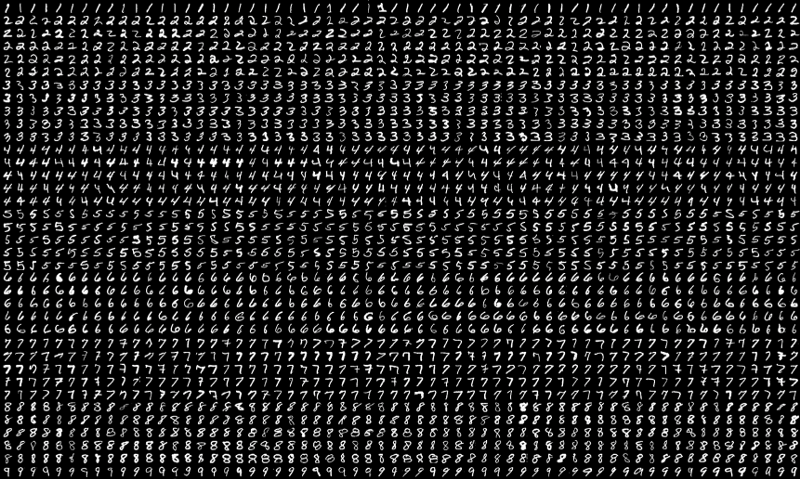

**Caption**: So many digits! 🔢 Can you classify them all?

For this exercise, we will look for the model with the best performance using Scikit's [`Grid Search`](https://duckduckgo.com/?q=gridsearchCV), which performs a ["round robin"](https://en.wikipedia.org/wiki/Round-robin_tournament) search on a set of possible hyperparameters to find the model with the best performance.

Search for Scikit's [`K-neighbors Classifier`](https://duckduckgo.com/?q=scikit+kneighbors) to find the documentation page. You will find a list of parameters that users can use when making the classifier.

Here is the list of tasks for this exercise.

1. Define a list of dictionaries with the set of hyperparameters that are to be tested: 
<table align='middle'>
  <tr>
    <th> Hyper-Parameter</th>
    <th colspan="5" scope="colgroup">Values to Test</th>
  </tr>
  <tr>
    <td scope="col" align='middle'>Weights</td>
    <td scope="col" colspan="2" align='middle'><i>uniform</i></td>
    <td scope="col" colspan="2" align='middle'><i>distance</i></td>
  </tr>
    <tr>
    <td scope="col" align='middle'># of Neighbors</td>
    <td scope="col" align='middle'><i>3</i></td>
    <td scope="col" align='middle'><i>4</i></td>
    <td scope="col" align='middle'><i>5</i></td>
    <td scope="col" align='middle'><i>6</i></td>
  </tr>
</table>

2. Instantiate the KNeighborsClassifier Model

3. Fit the models to your training data

4. Extract the optimal model parameters

5. Evaluate your best model

<br><br>Let's begin!

In [ ]:
# Begin by importing the KNeighersClassifier and GridSearchCV from scikit.
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

## **Q1) Set up the parameter dictionary of your [`GridSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)**  

In [ ]:
#@title Hint: Using grid_search
'''
Start by reading the documentation for the `param_grid` parameter of 
`GridSearchCV` (Grid Search with Cross-Validation) at the URL below
https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

In essence, here you'll be setting up the parameter grid using the information
from the table in point 1) in the list of tasks for this section.
''';

In [ ]:
# Fill in the blanks in the code below
param_grid = {'_______':['_______', '_______'], # 1st hyperparameter and the values it can take
              '_______':[_______, _______, _______, _______] # 2nd hyperparameter and the values it can take
              }

## **Q2) Make an instance of the [KNeighborsClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html) model***

In [ ]:
#@title Hint: Reminder of model instantiation
'''
No worries if you forgot what instantiating a class means.
Essentially, classes are like the blueprints for a house - they say how things
should be built, but you can't quite live in them! Similarly, a class defines 
the attributes and methods associated with a specific type of object, and when
we say that we _instantiate_ a class what we mean is that we'll create an 
instance of an object that follows the "blueprint" laid out by the class.

Most often, all you do is class the class object and feed it whatever arguments
it needs to create the object we're interested in. If you read the documentation 
for the kNeighborsClassifier, you'll see that it doesn't need any keyword 
arguments to define a model, though there are several optional ones you can
input. For today, create a model without using any arguments in the model class.
''';

In [ ]:
# Instantiate the imported model class
knn_clf = ________()

## **Q3) Use GridSearch's `fit` method to train your models.***

We will define a grid search using the `knn_clf` model and `param_grid`. 
We will set the number of **folds for the cross-validation to 6**, and use the most verbose setting to get the best idea of how well each cv run performs. 

In [ ]:
#@title Hints: Running a grid search with Scikit-Learn
'''
You can find the documentation for the sklearn implementation of grid searching
at the hyperlink below:
https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

When you use GridSearchCV, you'll have to instantiate it and tell it the model
you'll be searching with (e.g., a logistic regression classifier), a dictionary
with the hyperparameters and hyperparameter values that you want to search 
through (see example 1 below), and the number of folds to use for 
cross-validation.

Example 1: with the following dictionary:
{'solver':['newton-cg','lbfgs', 'liblinear']
 'class_weight':[{0:0.2,1:0.8}, 
                 {0:0.5,1:0.5},
                 {0:0.8,1:0.2}] } 
would try each of 3 solvers with each of the 3 different class weight schedules
''';

In [ ]:
#@title Hint: Help with the .fit() method
'''
You can find the documentation for the `fit()` method is 
https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html#sklearn.model_selection.GridSearchCV.fit)

In scikit's machine learning API, every model implements a '.fit()' method that
contains the subroutine needed to train the model using the data. As a general
rule, what the model expects is input data and -for supervised learning- target
data. 
''';

In [ ]:
# We define a grid search using the knn_clf model and param grid. We will set
# the number of folds for the cross-validation to 6, and use the most verbose
# setting to get the best idea of how well each cv run performs.


# Let's instantiate the scikit class used to do grid searches
grid_search = _______( 
    _______, # The model we're going to use in the search
    _______, # The method dictionary of parameters we'll iterate through in the search
    cv = _______, # The number of folds used to cross-validate
    verbose = 3) #Let's set the verbosity to the highest level: 3

In [ ]:
# Complete the code
grid_search.fit(_______,_______)

Now that the models have been trained, let's figure out which one is the best one. \

## **Q4) Fetch and print the optimal parameters and best score found with the grid search*** 
<center><font size=30>🔍</font></center>

In [ ]:
#@title Hint: GridSearch Attributes
'''
GridSearch essentially trains as many models as there are combinations of 
parameters in our search space. As it does so, it uses whatever score we 
specified (or the default score provided by the model, e.g.: Mean Square Error)
to determine if it's the best model it has found. If so, it stores it as the 
best model.

It stands to reason, then, that both the best score and best model are stored
as attributes in the search. You can access these using the best_score_ and 
best_params_ attributes
''';

In [ ]:
#Store the best parameters and best scores for the models
best_parameters = grid_search._______
best_score = grid_search._______

# And print them out. Try to make them nice!
print(f'_______{_______}',
      f'_______{_______}',
      sep='\n')


<a name="accuracy"></a>
Now it's time to test your model! Let's import the [accuracy score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html?highlight=accuracy%20score#sklearn.metrics.accuracy_score) metric from scikit and see how our model fares.

## **Q5) Use the grid_search's to predict the targets from the test dataset.** 

(we'll use this to evaluate the accuracy of your model!)

In [ ]:
#@title Hint: Importing scikit-learn metrics
'''
There are a myriad of ways to measure how well your model is working. Luckily
for us, the developers contributing to scikit-learn have implemented a large 
number of them in their metrics package - check out the documentation at the
link below:
https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics

We're working on a classification problem, so we need a metric suited for
evaluating a classification algorithm. A simple and often used metrics is the
accuracy score, which is simply the number of samples we classified correctly
divided by the total number of samples:

accuracy = true_positives / positives

There are many other metrics we could use! Check out some options in this
wikipedia page:
https://en.wikipedia.org/wiki/Precision_and_recall#Definition_(classification_context)

When importing a metric from scikit-learn, we can simply write, e.g.:
from sklearn.metrics import log_loss
''';

In [ ]:
#@title Hint: Predicting using a trained scikit-learn model

'''
The documentation for the `predict` method is found at the link below:
https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html#sklearn.model_selection.GridSearchCV.predict
''';

In [ ]:
#Import the accuracy metric
from sklearn._______ import _______

In [ ]:
#generate predictions from the best model
y_pred = grid_search.predict(______)

In [ ]:
#calculate the accuracy score using the imported metric
accuracy = _____(_____, _____)

In [ ]:
# And print out the accuracy of the model
print(f'The accuracy of the model is {accuracy:.1%}')

Congratulations! If you've done everything right, you should have a model with an accuracy of 96.9% We're so close to 97% that we can _taste_ it.
<center><font size=30>🍲</font></center>

Let's see if we can bridge the gap with a bit of [data augmentation](https://en.wikipedia.org/wiki/Data_augmentation), working off of the smaller mnist dataset we made in the previous part of the exercise. The type of augmentation we'll be using is _shifting_, in which the images in the dataset are shifted up/down/left/right by a number of pixels to make "new" datapoints. 

List of Tasks:

6. Augment the digit dataset using shifted versions of the images

7. Train a KneighborsClassifier model on the augmented data set using the best parameters found in Exercise 1

8. Evaluate the accuracy of the model trained with the augmented data


Let's start by importing the shift tool from SciPy. You can find the documentation for the shift function [here](https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.shift.html)

In [ ]:
# We will import shift form the scipy multi-dimensional image processing tools
from scipy.ndimage.interpolation import shift

And we'll define a function that shifts an image from out dataset up & down and/or left & right.

In [ ]:
# Using shift, we will write a function that shifts a single image left or right
def shift_image(image, dx, dy):
    image = image.reshape((28, 28))
    shifted_image = shift(image, [dy, dx], cval=0, mode="constant")
    return shifted_image.reshape([-1])

Let's go ahead and verify that the shift_image function works as intended... That way we won't run into issues further down the line.

## **Q6) Verify that the shift function is working as intended and plot a down-shifted and left-shifted data sample.***

In [ ]:
#@title Hint: Default shift directions
'''
When you think of shifts left/right and up/down, you may be used to thinking in
cartesian coordinates. That is, a shift right is a positive change in x and a 
shift left is a negative change in x. This is also true in most programming 
applications.

HOWEVER, when it comes to images in programming, a shift down is associated with
an _increase_ in the y value. This is the case with scipy's shift function. 
''';

In [ ]:
# Let's choose a random image from out training dataset
rnd_id = rnd_gen.integers(0,
                          _______.shape[0]) # dataset we're sampling

# And load the image associated with rnd_id from the dataset
image = _______[_______]

# Now, let's grab the same image as below and shift it down 5 pixels
shifted_image_down = shift_image(image, 
                                 _______, # dx
                                 _______) # dy

# and shift the original image left five pixels
shifted_image_left = shift_image(image, 
                                 _______, # dx 
                                 _______) # dy

In [ ]:
#@title Run this cell to plot the images we made in the cell above. You can always doubleclick it if you want to look at the source code 😀
# And then create a matplotlib figure where we'll plot the image
fig, axes = plt.subplots(1, # one row
                         3, # three columns
                         figsize=(12,3))

# Plot the original
axes[0].set_title("Original", fontsize=14)
axes[0].imshow(image.reshape(28, 28), # turn the flattened data back into a 28x28 image
          interpolation="nearest",
          cmap="Greys");

# Plot the down-shifted
axes[1].set_title("Shifted down", fontsize=14)
axes[1].imshow(shifted_image_down.reshape(28, 28), 
          interpolation="nearest", 
          cmap="Greys");

# Plot the left-shifted
axes[2].set_title("Shifted left", fontsize=14)
axes[2].imshow(shifted_image_left.reshape(28, 28), 
          interpolation="nearest", 
          cmap="Greys");

Now that we've verified that the shift function works, let's go ahead and use it to augment our training dataset.

## Q7) Augment the training dataset

In [ ]:
# transform the datasets into lists of images. This will make it easy to 
# iterate & append the shifted images
X_train_augmented = [image for image in _____]
y_train_augmented = [label for label in _____]

print(f'We have {len(X_train_augmented)} samples originally')

In [ ]:
# Make a tuple of shifts to apply to the datasets as augmentation.
# a shift of 1 pixel right and 1 up is recommended for the first shift tuple,
# and a shift of 1 pixel left, and 1 pixel down are recommended for the second tuple.
shifts = ((_______,_______),
          (_______,_______))

In [ ]:
# Let's iterate through our shifts. Remember that each shift includes a value
# for dx and dy
for _____, _____ in shifts:

    # For each shift defined, we'll iterate through the dataset to shift each 
    # image
    for image, label in zip(X_train, y_train):
        X_train_augmented.append(shift_image(image, dx, dy))
        y_train_augmented.append(label)

In [ ]:
# Transform the lists back into numpy arrays
X_train_augmented = np._______(_______)
y_train_augmented = np._______(_______)

In [ ]:
#Let's print out the number of samples we have after augmenting!
print(f'We have {len(_______)} samples after augmenting')

If everything is working as intended, you shoudl have 27 000 samples. Thats *a lot* of handwritten digits.
<center><font size=30>✍ 😖</font></center>

In [ ]:
#@title Run this cell to shuffle the augmented data...

# Generate scrambled indices list
aug_shuffler = rnd_gen.permutation(len(X_train_augmented))

# Shuffle the array using the scrambled indices - that way the input data order
# matches the target data order
X_train_augmented = X_train_augmented[aug_shuffler]
y_train_augmented = y_train_augmented[aug_shuffler]


We now have an augmented dataset! Let's train a model using the best hyperparameters we previously found with our grid search.

## **Q8) Load a new K Nearest Neighbors classifier using the `.best_params_` information***

Hint: The documentation of the [`KNeighborsClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html) is [at this link](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)

In [ ]:
#Complete the code
knn_clf = _______( # The model class we're instantiating
    _______ = _______['________'], # Load in our best number of neighbors
    _______ = _______['________') # Load in our best weight type

## **Q9) Fit the new model using the augmented x and y data***

Hint: The `fit` method of the `KNeighborsClassifier` is documented [at this link](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html#sklearn.neighbors.KNeighborsClassifier.fit)

In [ ]:
knn_clf.fit(_______, # The input we're fitting 
            _______) # The labels we're fitting

## **Q10) Evaluate the accuracy of the model trained with the augmented data***

Hint: You should have already loaded the `accuracy_score` [here](#accuracy)

In [ ]:
# Let's get the predictions from our model
y_pred = _____.predict(______)

# And use them to calculate the accuracy
accuracy = accuracy_score(_____, _____)

# We'll finish by printing out our accuracy...
print(f'The accuracy for our model training on augmented data is {accuracy:.1%}!')

Congratulations for finishing the first exercise! If everything went well _and_ you used the exact same arguments we did, you should have gotten an accuracy of 97.5% \

<center><font size=30>🥳</font></center>

## Exercise 2 - Tackling the Titanic dataset

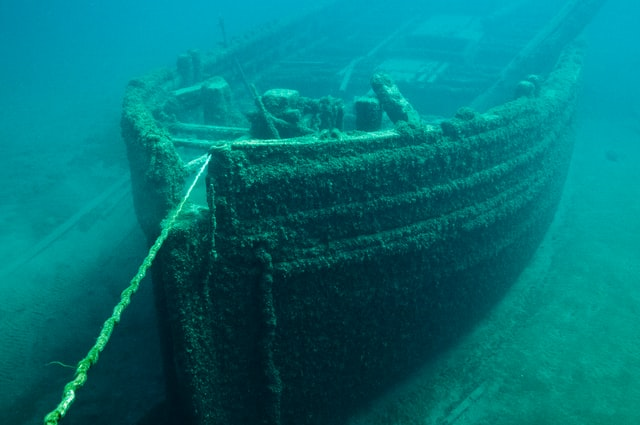

**Caption**: Can you predict which passengers will survive their ride on the Titanic? 🚣 🧊

In this exercise we will be attempting to predict whether or not a passenger on the titanic survived or not, based on their attributes (e.g., age, sex, passenger class, where they embarked, and so on). For this exercise, we will be relying on [Pandas](https://en.wikipedia.org/wiki/Pandas_(software)) [DataFrames](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html).


Let's take a moment to talk about our dataset! The dataset we'll be using today was part of a machine learning challenge - what this means for _you_ is that today we have training data with labels, but ***our test data has no test labels*** (i.e., we have y_train but not y_test).

Exercise Tasks:

9. Calculate the mean of the age the corresponding standard deviation for the female and male populations in the passenger list. 

10. Set up a pipeline for the numerical attributes that implements an "median" imputer and a scaler 

11. Set up a pipeline for the categorical attributes that implements a "most frequent" imputer and a one-hot categorical encoder

12. Prepare the training and testing datasets for the Titanic data. What's the difference between `.fit_transform()` and `.transform()` ?

13. Train a random forest classifier with 100 estimators 

14. Make a prediction using the trained random forest classifier. How good is the accuracy? 

15. Compare this to a 10-fold cross validation mean.

16. Train a support-vector clustering algorithm and compare its 10-fold cross validation mean to that of the random forest classifier.

Let's begin by fetching the data from the internet and loading it into memory. To do this, the code cell defines a `fetch_titanic_data` function that downloads the titanic dataset and a `load_titanic_data` function that let's us load the "train.csv" data or "test.csv" data.

In [ ]:
#@title `fetch_titanic_data` and `load_titanic_data` definition. Double click here to see the source code.
# Setup - First, We need to fetch the data from the internet...
import os
import urllib.request
import pandas as pd


TITANIC_PATH = os.path.join(PROJECT_ROOT_DIR,"datasets", "titanic")
DOWNLOAD_URL = "https://raw.githubusercontent.com/ageron/handson-ml2/master/datasets/titanic/"

# Define the function that will download the titanic data... 
def fetch_titanic_data(url=DOWNLOAD_URL, path=TITANIC_PATH):
    if not os.path.isdir(path):
        os.makedirs(path)
    for filename in ("train.csv", "test.csv"):
        filepath = os.path.join(path, filename)
        if not os.path.isfile(filepath):
            print("Downloading", filename)
            urllib.request.urlretrieve(url + filename, filepath)

# And define the function that loads the data into memory...
def load_titanic_data(filename, titanic_path=TITANIC_PATH):
    csv_path = os.path.join(titanic_path, filename)
    return pd.read_csv(csv_path)

## **Q11) Fetch and load the titanic training and test data. Then, set the passenger ID as the index.**

In [ ]:
# Let's start by fetching the titanic data
_______()

In [ ]:
# And load the training data and test data 
train_data = load_titanic_data("_______.csv")
test_data = load_titanic_data("_______.csv")

In [ ]:
# We will explicitely set the PassengerId attribute as the DataFrame index 
# since it is unique to each passenger
train_data = train_data._______("PassengerId")
test_data = test_data._______("PassengerId")

The data is already split into a training set and a test set. However, please remember that *the test data* does **not** contain the labels: your goal is to train the best model you can using the training data, then make your predictions on the test data.

Let's take a peek at the training set. Use the `.head()` method to return the first 5 rows of the training dataset. 

*If you're on colab, you can instead use Google's interactive data table!*

-----------------------

The dataset should include the following attributes:
* **PassengerId**: a unique identifier for each passenger
* **Survived**: that's the target, 0 means the passenger did not survive, while 1 means he/she survived.
* **Pclass**: passenger class.
* **Name**, **Sex**, **Age**: self-explanatory
* **SibSp**: how many siblings & spouses of the passenger aboard the Titanic.
* **Parch**: how many children & parents of the passenger aboard the Titanic.
* **Ticket**: ticket id
* **Fare**: price paid (in pounds)
* **Cabin**: passenger's cabin number
* **Embarked**: where the passenger embarked the Titanic. C=Cherbourg, Q=Queenstown, S=Southampton.

In [ ]:
# Load Google's data table to display the dataframe interactively
from google.colab import data_table
data_table.DataTable(train_data, num_rows_per_page=10)

Using DataFrames allow us to easily calculate statistics from the data. Here we will use the .median() and .std() methods to get an picture of the passenger population.

## **Q12) Calculate the median and standard deviation for each listed sex category**

Hint: The "pre-filled" code below uses `pandas`' native [`median`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.median.html) and [`std`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.std.html) functions. If you prefer using [`Numpy`](https://numpy.org/doc/stable/index.html), `Numpy` also has functions for the median and the standard deviation. 

In [ ]:
# Calculate the median and standard deviation for the age of passengers listed
# as having a female sex
med_age_f = train_data[train_data["_______"]=="_______"]["_______"]._______()
stddev_age_f = train_data[train_data["_______"]=="_______"]["_______"]._______()

# Calculate the median and standard deviation for the age of passengers listed
# as having a male sex
med_age_m = train_data[train_data["_______"]=="_______"]["_______"]._______()
stddev_age_m = train_data[train_data["_______"]=="_______"]["_______"]._______()

print_out=(f'The female population had a median age of {med_age_f:.1f}'
           f' with a standard deviation of {stddev_age_f:.2f} \n'
           f'The male population had a median age of {med_age_m:.1f}'
           f' with a standard deviation of {stddev_age_m:.2f} \n')

print(print_out)

If you did everything right so far, you'll find a median age of 27/29 with a standard deviation of 14.11/14.68 for female/male sexes. 

It's important that we be aware of the gaps in the data available. In order to do this, let's rely on the DataFrames `.info()` method:

In [ ]:
train_data.info()

Okay, the **Age**, **Cabin** and **Embarked** attributes are sometimes null (less than 891 non-null), especially the **Cabin** (77% are null). We will ignore the **Cabin** for now and focus on the rest. The **Age** attribute has about 19% null values, so we will need to decide what to do with them. One reasonable option is to replace null values with the median age. We could be a bit smarter by predicting the age based on the other columns (for example, the median age is 37 in 1st class, 29 in 2nd class and 24 in 3rd class), but we'll keep things simple and just use the overall median age. 

(Note: this will be done in a later step, when we develop the data pipeline)

The **Name** and **Ticket** attributes may have some value, but they will be a bit tricky to convert into useful numbers that a model can consume. So for now, we will ignore them.

Let's take a look at the numerical attributes:

In [ ]:
train_data.describe()

* Less than 50% of the passengers survived (About 38%, to be more precise). That's close enough to 40%, so accuracy will be a reasonable metric to evaluate our model.
* The mean **Fare** was £32.20, which does not seem so expensive, but the [Bank of England estimates](https://www.bankofengland.co.uk/monetary-policy/inflation/inflation-calculator) the value to be around _£3889_ in 2021.
* The mean **Age** was a little under 30 years old.
* Over half of the passengers were in 3rd Class 

We will now verify that the `Survived` class is indeed 0 or 1. 

We will also look at the types of values we have in our categorical variables, namely:  `Passenger Class`, `Sex`, and `Embarqued`.

Reminder: 
The Embarked attribute tells us where the passenger embarked: C=Cherbourg, Q=Queenstown, S=Southampton.

In [ ]:
#@title Use this cell to print out the values and counts of the catergorical classes... 
# Initialize the string
print_out = ""

# Define the columns to iterate through 
var_list = ["Survived", "Pclass", "Sex", "Embarked"]

# Append the information to our print out text by iterating
for var in var_list: print_out += f'{train_data[var].value_counts()} \n\n'

# and print out the final string
print(print_out)

Now let's build our [data preprocessing pipelines](https://en.wikipedia.org/wiki/Data_pre-processing), starting with the pipeline for numerical attributes.
In this section we will set up a [Pipeline class](https://duckduckgo.com/?q=sklearn+pipeline), which will fill the missing values in the columns using the mean value (see the [SimpleImputer documentation](https://duckduckgo.com/?q=sklearn+simpleimputer)) and scale the data (see the [StandardScaler documentation](https://duckduckgo.com/?q=sklearn+standardscaler)).

## **Q13) Set up the numerical attribute pipeline using a) an "imputer" that uses SimpleImputer with "median" set as the strategy and b) a "scaler" that uses a default StandardScaler**

Hint: The documentation for the `Pipeline` class is [at this link](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html)

In [ ]:
# Let's import the classes we'll need from scikit-learn in order to set up
# our data pipeline.
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

# The Pipeline needs to be initiated with a list containing the name of the
# preprocessor (e.g., "imputer" or "scaler").
num_pipeline = _______([ # We'll instantiate the pipeline class
     ("_______", _________(_________="________")), # Which will use the imputer
     ("_______", _________() ) ]) # as well as the scaler

Now we can build the pipeline for the categorical attributes. Here, we will use [one-hot encoding](https://en.wikipedia.org/wiki/One-hot#Machine_learning_and_statistics) using the [OneHotEncoder](https://duckduckgo.com/?q=sklearn+onehotencoder) preprocessor in Scikit.


## **Q14) Set up the categorical attribute pipeline using: a) an "imputer" that uses [`SimpleImputer`](https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html) with "most_frequent" set as the strategy and b) a "cat_encoder" that uses a [`OneHotEncoder`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) with the sparse parameter set to `False`**

In [ ]:
# Let's import the One Hot Encoder function from scikit-learn, and set up our
# categorical data pipeline
from sklearn.preprocessing import OneHotEncoder

cat_pipeline = _______( [ # Once again we instantiate the pipeline class
    ("________", _________(_________="________")), # And set up an imputer with a strategy
    ("________", _________(_________=________)) ] ) # and an encoder with a given sparsity parameter

Finally, let's join the numerical and categorical pipelines using scikit's [ColumnTransformer](https://duckduckgo.com/?q=sklearn+ColumnTransformer):

In [ ]:
from sklearn.compose import ColumnTransformer

num_attribs = ["Age", "SibSp", "Parch", "Fare"]
cat_attribs = ["Pclass", "Sex", "Embarked"]

preprocess_pipeline = ColumnTransformer( [("num", num_pipeline, num_attribs),
                                          ("cat", cat_pipeline, cat_attribs) ] )

We now have a preprocessing pipeline that takes the raw data and outputs numerical input features that we can feed to any Machine Learning model we want, and we can also generate the truth variable from the 'Survived' data.

Let's generate our train and test data.

--------------------
Note! We will continue using X_train, y_train, X_test, and y_test as the variable names for our training and testing datasets. However, the notebook only has one namespace. Thus, runnng the code below will overwrite the X_train/test and y_train/test variables from exercises 1 & 2. 

## **Q15) Prepare the training and testing datasets. Think about the difference between `.fit_transform()` and `.transform()`!**

Hint 1: Remember to load "Survived" into `y_train`!

Hint 2: Here are the documentation links for the [`transform`](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html#sklearn.pipeline.Pipeline.transform) and [`fit_transform`](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html#sklearn.pipeline.Pipeline.fit_transform) methods of the [`Pipeline`](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) class.

Hint 3: Because the dataset is from a Kaggle competition, there is no "Survived" category in the test set `test_data` to not give away the answer.

In [ ]:
# Let's preprocess our datasets!
X_train = preprocess_pipeline._______( # Fit your pipeline using the training input data and transform the training input data in one step!
              _______[_______ + _______] ) # load the categorical and numerical attributes from the training dataframe

X_test =  preprocess_pipeline._______( # Transform the testing input data and transform the training data in one step!
              _______[_______ + _______] ) # load the categorical and numerical attributes from the testing dataframe

y_train = ________["_______"] # Load whether or not the passengers in the training survived into y_train

# You might be wondering about y_test. Remember, since the data came from a
# Kaggle competition, we don't actually have y_test! 

In [ ]:
#@title Let's print a sample to take a loot at the data being produced
for idx, attrib in np.ndenumerate(np.hstack((num_attribs,cat_attribs))):
    print(f"{attrib} has a value of {X_train[0][idx]}")

If you have done everything as we planned out so far, you should see the following:

Age has a value of -0.5657358173332453 <br>
SibSp has a value of 0.4327933656785018 <br>
Parch has a value of -0.4736736092984604 <br>
Fare has a value of -0.5024451714361923 <br>
Pclass has a value of 0.0 <br>
Sex has a value of 0.0 <br>
Embarked has a value of 1.0 <br>

Now that we've finally prepared the pipeline, we can begin training algorithms!
Let's start by training a type of classifier called a [`RandomForestClassifier`](https://duckduckgo.com/?q=scikit+randomforestclassifie). This type of a classifier is an _ensemble classifier_, which employs a number of estimators that we have to define. Today, we will use 100 members in our ensemble.

## **Q16) Import a RandomForestClassifier from scikit and instantiate it with 100 estimators. Then, fit the model**

Hint: The documentation for the `RandomForestClassifier` is [at this link](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)

In [ ]:
# Let's import the scikit implementation of random forest classifiers
from sklearn._______ import _______

In [ ]:
# And now let's instantiate the RandomForestClassifier class
forest_clf = RandomForestClassifier(_______=_______, # Set our number of estimators 
                                    random_state=rnd_seed) # And set our random seed for consistent results

In [ ]:
# We end by fitting the model
forest_clf._______(_______,_______)

Great, our model is trained! Let's use it to make predictions on the test set. Let's also check the accuracy of our model on the test dataset.

Wait a second... *we don't have labels for our test dataset!* 
<center><font size=30>😯</font></center>

What do we do now? Well, the best we can do is to check how well our model is able to fit our training data. \
***Please note that we do this with the very real risk of overfitting our training data!!!***


## **Q17) Predict a set of answers using the trained model and compare it using the accuracy_score metric. Then, print out a statement reporting the accuracy**

*Hint 1: [Here's the documentation](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html) for the `accuracy_score` metric*

*Hint 2: You don't have a set of labels for the test set (i.e., you don't have `y_test`), so you can't measure the accuracy using `X_test`. You do, however, have another dataset with both inputs `X` and labels `y`!*

*Hint 3: Though you won't be able to know if the model is over/underfitting the data if you measure the accuracy on the train set, it **will** give you an idea as to whether the model is able to make accurate predictions from the input data.*

In [ ]:
# Let's import the accuracy score implementation in scikit-learn
from _______._______ import _______

# Then let's get predictions from our model
y_pred = _______._______(_______)

# Let's calculate the accuracy...
accuracy = _______(_______, # We'll need our ground truth
                   _______) # and our predictions
print(f'The accuracy we got on our training dataset is {accuracy:.1%}')

If you did everything like we did during development of the notebook, you should get an accuracy of 98.0%! However, this accuracy is the performance of the model to predict the data that it was trained on. If we make the analogy to a student, *we gave them the list of questions and answers before the test*. Are we surprised that they did well?

While our model gave us a prediction and we were able to compare how accurate our predictions were, we're also interested in knowing how good our model really is. 

It's true that now we could just build a CSV file with the predictions based on the test set (respecting the format excepted by Kaggle), then upload it and hope for the best. 

***But we can do better than hope.***

Why don't we use cross-validation to have an idea of how good our model is? This means we'll divide the data into several groups of data, and we'll use all but one for training and test on the remaining group. We'll do this as many times as we have groups, which will give use an idea of how well our model is able to predict data it has never seen before.

This schematic from the scikit learn documentation might be useful to help you understand...
<center><img src='https://unils-my.sharepoint.com/:i:/g/personal/tom_beucler_unil_ch/EYHr_ysnBVtMpFdG1q4apgABfkARNM6Q-CyXbFM5cQ0iEg?download=1' width=70%><br>
<a href='https://scikit-learn.org/stable/modules/cross_validation.html'>Image Source: Scikit-Learn Cross Validation Documentation</a></center>

## **Q18) Import the cross_val_score function and produce a set of 10-fold cross validation scores using the training data. Then, print the mean score. How does it compare with the answer to Q14?**

Hint: You may consult [the documentation of `cross_val_score`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html)

In [ ]:
# Let's start by importing the cross validation score class from scikit-learn
from _______._______ import _______

# Let's instantiate the imported class...
forest_scores = cross_val_score(_______, # Which will need the model to evaluate 
                                _______, # The input data to use
                                _______, # The corresponding target data
                                cv=_______) # And the number of folds for evaluation

print(f'The mean score is {_______.mean():.1%}')

If you did everything the way we did, you'll get a mean accuracy of 81.4%. 

We will now compare to the [leaderboard](https://www.kaggle.com/c/titanic/leaderboard) for the Titanic competition on Kaggle. How does our model compare?

Don't be discouraged by those with 100% accuracy - since you can easily find the [list of victims](https://www.encyclopedia-titanica.org/titanic-victims/) of the Titanic, it seems likely that there was little Machine Learning involved in their performance.

Let's move on from random forests and try an `SVC`, i.e., a [support-vector clustering algorithm](https://www.jmlr.org/papers/volume2/horn01a/horn01a.pdf). You can find the scikit documentation [here](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html).

## **Q19) Train a support-vector clustering algorithm and generate a set of cross-validated scores**

Hint: Don't hesitate to recycle code from before!

In [ ]:
# Let's import the SVC class and instantiate a model
from sklearn._______ import _______
svm_clf = _______(gamma="auto")

svm_scores = _______(_______,
                     _______,
                     _______,
                     cv=_______)
print(f'The mean score is {_______.mean():.1%}')

If everything went well, this model should look better. Notice though that what we've printed so far is the mean score from the cross validation. While we do appreciate models having higher mean accuracy, consistency is also very important when making predictions! Let's visualize the scores using a box plot (Géron thanking Nevin Yilmaz as the proponents of this idea), where the points will represent the performance on the testing fold in each run. 

It's also important to note that the `boxplot()` function detects outliers (called "fliers") and does not include them within the whiskers. Specifically, if the lower quartile is  Q1  and the upper quartile is  Q3 , then the interquartile range  IQR=Q3−Q1  (this is the box's height), and any score lower than  Q1−1.5×IQR  is a flier, and so is any score greater than  Q3+1.5×IQR . 

But instead of just looking at the mean accuracy across the 10 cross-validation folds, let's plot all 10 scores for each model, along with a box plot highlighting the lower and upper quartiles, and "whiskers" showing the extent of the scores (thanks to Nevin Yilmaz for suggesting this visualization). Note that the `boxplot()` function detects outliers (called "fliers") and does not include them within the whiskers. Specifically, if the lower quartile is $Q_1$ and the upper quartile is $Q_3$, then the interquartile range $IQR = Q_3 - Q_1$ (this is the box's height), and any score lower than $Q_1 - 1.5 \times IQR$ is a flier, and so is any score greater than $Q3 + 1.5 \times IQR$.

In [ ]:
#@title We'll make a quick boxplot to compare the SVM and Random Forest CV scores
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
plt.plot([1]*10, svm_scores, ".")
plt.plot([2]*10, forest_scores, ".")
plt.boxplot([svm_scores, forest_scores], labels=("SVM","Random Forest"))
plt.ylabel("Accuracy", fontsize=14)
plt.show()

If all goes as expected, your plot should look like this:
<center><img src='https://unils-my.sharepoint.com/:i:/g/personal/tom_beucler_unil_ch/EZCeQavg9tFKj0kVl0fUNhUBrGfi_BcpOxOe4qbN3tyzeg?download=1'></center>

The random forest classifier should have gotten a very high score on one of the 10 folds, but overall should have a lower mean score and a bigger spread. This suggests that the SVM classifier is more likely to generalize well. 

## Bonus Questions
**Exercise 1 Bonus Objectives:**

1. Train and evaluate the models using precision as the metric

2. Extract & plot instances in which the model was confused 

3. Create an imbalanced dataset and study the effect on the model

5. Implement a rotation augmentation strategy

6. Try addressing the imbalance in the dataset using data augmentation


**A.)** We trained and tested the model's performance using accuracy as the metric. What happens when you use precision as the scoring metric instead? Note: you'll have to redefine the grid_search scoring parameter

**B.)** Extract some samples that the model made a mistake on and plot them. Can you tell what the digit is?

**C.)** In the setup we reduced the size of the dataset while ensuring that it remained perfectly balanced (<font color='blue'>♦</font> <font color='yellow'>♦</font> <font color='red'>♦</font> <font color='purple'>♦</font> <font color='green'>♦</font><font color='orange'>♦</font>). What happens to the performance of the model when using an unbalanced dataset? Make one of the digits dominate the dataset (e.g., making over 50% of the dataset one of the digits) and try training the algorithm and test it on the _balanced_ test dataset. 

**D.)**We've implemented a shift strategy, but there's a myriad of ways of augmenting your dataset! Try implementing a rotation augmentation strategy using Scipy's ndimage.rotate

**E.)** We've implemented shifts as augmentations in the dataset. In a previous challenge we developed an unbalanced dataset - try addressing the imbalance in the dataset by augmenting the dataset!

**Exercise 2 Bonus Objectives:**

1. Choose two other models and try using them to predict whether or not a passenger would survive. Use grid-search to try out several hyperparameters and determine which model worked best out of the four.

2. Try converting numerical attributes to categorical attributes, such as age group instead of age, or those travelling alone vs with company.